In [1]:
from scipy.stats import chisquare
from scipy import stats
import urllib.request
import string
import requests
from bs4 import BeautifulSoup
import pandas as pd
import multiprocessing
import gensim
import sys
import spacy
# nlp=spacy.load('en')
import seaborn as sns
import nltk
from nltk.tokenize import WordPunctTokenizer
tknzr = WordPunctTokenizer()
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from scipy import spatial
from collections import Counter
import numpy as np
from collections import defaultdict
from pprint import pprint
from gensim import corpora
import re
import logging
import requests
import urllib 
import re
import sys
import zipfile
from glob import glob
import statsmodels.api as sm
import scipy
import scipy.stats as ss
from scipy.signal import savgol_filter
import random
np.set_printoptions(precision=2)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import metrics
from sklearn.cluster import KMeans
# from the demo
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.corpus import names
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [2]:
# Load your usual SpaCy model (one of SpaCy English models)
import spacy
nlp = spacy.load('en')
# load NeuralCoref and add it to the pipe of SpaCy's model
import neuralcoref
coref = neuralcoref.NeuralCoref(nlp.vocab)
nlp.add_pipe(coref, name='neuralcoref')

2020-07-21 23:50:08,342 : INFO : Loading model from /Users/xuhuimin/.neuralcoref_cache/neuralcoref


In [3]:
def flushPrint(s):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % s)
    sys.stdout.flush()
    
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

def cultureD2(model, words):
    cultures = []
    for word in words:
        if (word[0] in model.wv.vocab) & (word[1] in model.wv.vocab):
            cultures.append(normalize(normalize(model[word[0]]) - normalize(model[word[1]])))
        else:
            print(word)
    culturev = normalize(np.mean(cultures, axis=0))
    return culturev

def storyv(model,words):
    veclist=[]
    for w in words:
        if w in model.wv.vocab:
            veclist.append(normalize(model[w]))
    storyv=normalize(np.mean(veclist,axis=0))
    return storyv

def projection(storyv, culturev):
    # cosine similarity
    return (1 - spatial.distance.cosine(storyv, culturev))
           
def cosine2angle(i):
    return np.arccos(i) / np.pi * 180 #长度换角度

def normalized(x):
    x= np.array(x)
    return (x-np.mean(x))/np.std(x)


In [4]:
swords = [
    ['success','failure'],
    ['succeed','fail'],
    ['lucky', 'unlucky'],
    ['fortunate', 'unfortunate'],
    ['happy', 'unhappy'],
    ['glad', 'sad'],
    ['joy', 'sorrow'],
    ['smile', 'tear']
] # success words

In [5]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

2020-07-21 23:50:11,761 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2020-07-21 23:50:57,563 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


In [6]:
success_vector = cultureD2(model, swords)
success_word = [i[0] for i in model.similar_by_vector(success_vector, 1)]

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app
2020-07-21 23:51:02,288 : INFO : precomputing L2-norms of word weight vectors


In [11]:
 # 将文本中的标点符号过滤掉
def filter_punc(sentence):
    for c in string.punctuation: #去标点 
        sentence = sentence.replace(c, ' ')
    return(sentence)

In [12]:
import re, sys, getopt

PUNCTUATION = [ch for ch in """(){}[]<>!?.:;,`'"@#$%^&*+-|=~/\\_"""]
LETTERS     = [ch for ch in "abcdefghijklmnopqrstuvwxyz"]
CONSONANTS  = [ch for ch in "bcdfghjklmnpqrstvwxz"] # Need this for Mr. Mss. abbreviations.
WHITESPACE  = [ch for ch in " \t\n\r\f\v"]          # Need this to split words.
DASHES      = [ch for ch in u"鈥撯€�"]                  # Not to be confused with hyphen.

is_uppercase   = lambda s: len(s)>0 and s==s.upper()                          # Goodbye => True
is_capitalized = lambda s: len(s)>0 and s[0].isalpha() and s[0]==s[0].upper() # GOODBYE => True

digits = re.compile("^[0-9]+$")
is_int = lambda s: digits.search(s) != None

# regex pattern for entities: &amp; &#164;
entity = "&[a-z]+;|&#[0-9]+;"

class Range(dict):
    
    def __init__(self, items=[]):
        dict.__init__(self, items)
        self.patterns = []
        
    def __contains__(self, str):
        if dict.__contains__(self, str): 
            return True
        for p in self.patterns:
            if p.search(str) != None: 
                return True
        return False

def in_any(word, ranges=[]):
    for rng in ranges:
        if word in rng: return True
        
abbreviations = [
    "Adm.", "Ala.", "Ariz.", "Ark.", "Aug.", "B.C.", "Bancorp.", "Bhd.", "Brig.", "Bros.", "CO.", 
    "CORP.", "COS.", "ca.", "Calif.", "Capt.", "Cie.", "Cmdr.", "Co.", "Col.", "Colo.", "Conn.", "Corp.", 
    "Cos.", "Cpl.", "D-Mass.", "D.C.", "Dec.", "Del.", "Dept.", "Dr.", "E.g.", "Etc.", "Ex.", "Exch.", 
    "Feb.", "Fla.", "Fri.", "Ga.", "Gen.", "Gov.", "INC.", "Ill.", "Inc.", "Ind.", "Jan.", "Jansz.", 
    "Jos.", "Jr.", "Kan.", "Ky.", "L.A.", "La.", "Lt.", "Ltd.", "Maj.", "Mass.", "Md.", "Messrs.", 
    "Mfg.", "Mich.", "Minn.", "Miss.", "Mo.", "Mon.", "Mr.", "Mrs.", "Ms.", "Mt.", "N.C.", "N.J.", 
    "N.Y.", "NFATc.", "Neb.", "Nev.", "No.", "Nos.", "Nov.", "O.J.", "Oct.", "Okla.", "Ont.", "Ore.", 
    "P.T.", "Pa.", "Ph.", "Prof.", "Prop.", "Pty.", "R.I.", "R.J.", "Rep.", "Reps.", "Rev.", "S.C.", 
    "Sat.", "Sen.", "Sens.", "Sep.", "Sept.", "Sgt.", "Sol.", "Sr.", "St.", "Sun.", "Tenn.", "Tex.", 
    "Thu.", "Tue.", "U.K.", "U.N.", "U.S.", "Va.", "Vt.", "W.J.", "W.Va.", "Wash.", "Wed.", "Wis.", 
    "Wyo.", "a.m.", "cit.", "def.", "ed.", "eds.", "e.g.", "etc.", "ft.", "i.e.", "op.", "p.m.", "pp.", 
    "sc.", "v.", "vs.", "Biol.", "Chem.", "beta4.", "Struct.", "Funct.", "Natl.", "Acad.", "Sci.",
    "Biochem.", "Cell.", "Proc.", "Res.", "Lond.", "Nat.", "Dev.", "Camb.", "Profilin.", "Thymosin-beta4."
]

class Abbreviations(Range):
    
    def __init__(self, known=[]):
        """ A dictionary of known abbreviations, extended with patterns of likely abbreviations.
            word in Abbreviations() == True if word is a known or likely abbreviation.
            Periods in English are ambiguous,
            marking end of sentence, abbreviation, decimal point or ellipsis.
            - Simple rule: "every point is a sentence break" is 93.20% correct for Brown corpus.
            - Fix decimal points: 93,64% correct.
            - Fix single letter abbreviations (T. De Smedt), alternating letters (i.e. U.S.),
              and capital letter followed by consonants (Mr. Assn.): 97.7% correct.
            - Fix with dictionary of known abbreviations: up to 99,07 accuracy.
            http://bulba.sdsu.edu/~malouf/ling571/13-token-bw.pdf
        """
        Range.__init__(self, [(x,True) for x in known])
        self.patterns = [
            re.compile("^[A-Za-z]\.$"),                       # single letter, "T. De Smedt"
            re.compile("^([A-Za-z]\.)+$"),                    # alternating letters, "U.S."
            #re.compile(".+\.[,;]$"),                         # followed by punctuation, "dept.,"
            re.compile("^[A-Z]["+"|".join(CONSONANTS)+"]+.$") # capital followed by consonants, "Mr."
        ]
        
    def __contains__(self, word):
        return word.endswith(".") and Range.__contains__(self, word)

abbreviations = Abbreviations(abbreviations)
# # from https://www.clips.uantwerpen.be/BiographTA/tokenizer.py

In [13]:
len(abbreviations)

153

In [14]:
def pre_process(data):
    for w in abbreviations:
        data = data.replace(w,' ')
    data = data.replace('\r',' ').replace('\n',' ').replace('\t',' ')
    data = re.split('[.?!]',data) # cut the sentence
    tknzr = WordPunctTokenizer()
    data = [tknzr.tokenize(i) for i in data]
    data=[i for i in data if len(i)>1]
    return data

In [15]:
def process_all_word(data):
    tknzr = WordPunctTokenizer()
    data = tknzr.tokenize(data)
    return data

def word_to_emotion(data):
    w=[]
    for da in data:
        d=[]
        for word in da:
            try:
                if (word.lower() not in stopword):#&(word not in names):
                    sim = 90-cosine2angle(projection(model[word],success_vector))
                    if (sim<-3)|(sim>3):
                        d.append(sim)
            except:
                pass
        w.append(np.mean(d))
    return w

In [16]:
with open('./stopword.txt','r') as f:
    stopword=f.readlines()
stopword=[i.split('\n')[0] for i in stopword]

In [17]:
def slope(cum_e,tp):
    threshold=len(w)/30
    tp_e=[[i,cum_e[i]] for i in tp]
    a=[]
    for i in range(len(tp_e)-1):
        if (tp_e[i+1][0]-tp_e[i][0])>threshold:
            a.append(i+1)

    a=[0]+a+[len(tp_e)]

    b=[]
    for i in range(len(a)-1):
        b.append(tp_e[a[i]:a[i+1]])
        b=[i for i in b if len(i)!=0]
    return b

### figure 1

In [2]:
with open ('./1661199.txt','r') as f:
    data=f.read()
data1=pre_process(data)
doc1=nlp(data)._.coref_resolved
doc1=pre_process(doc1)
w=word_to_emotion(data1)
tp=[26, 27, 28, 33, 35, 52, 53, 54, 55, 57, 59, 75, 76, 89, 90, 93, 95, 96] #when main characters encouter together   
w=[0 if np.isnan(i)==True else i for i in w]
cum_e2=np.cumsum(normalized(w))

In [53]:
f=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 81, 84, 85, 86, 87, 88, 89, 90, 91, 93, 95, 96]
# when female character appear in the nth sentence
f_cn=[w[i] for i in f]
m=[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 52, 53, 54, 55, 57, 59, 65, 66, 67, 75, 76, 82, 83, 89, 90, 93, 95, 96]
# when male character appear in the nth sentence
m_cn=[w[i] for i in m]
f_cn=normalized(f_cn)
m_cn=normalized(m_cn)
diction_m=dict(list(zip(m,m_cn)))
m_cn=np.cumsum([diction_m[i] if i in diction_m else 0 for i in range(len(w))])
diction_f=dict(list(zip(f,f_cn)))
f_cn=np.cumsum([diction_f[i] if i in diction_f else 0 for i in range(len(w))])
m_b=slope(m_cn,tp)
f_b=slope(f_cn,tp)

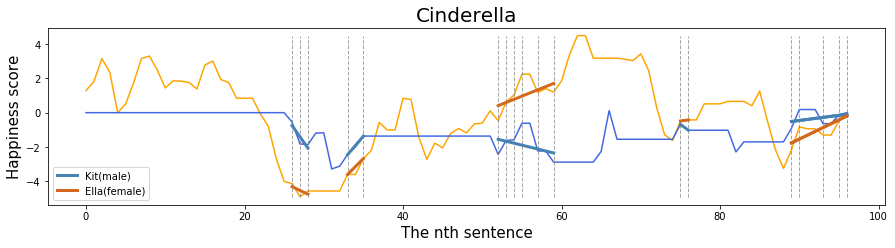

In [65]:
fig = plt.figure(figsize=(15,15))
ax=fig.add_subplot(411)
plt.plot(range(len(w)),f_cn,color='orange')
plt.plot(range(len(w)),m_cn,color='royalblue')
for i in tp:
    plt.plot([i,i],[np.min(list(m_cn)+list(f_cn)),np.max(list(m_cn)+list(f_cn))],color='grey',linestyle='--',alpha=0.7,linewidth=1)
    
for i in m_b:
    if len(i)>1:
        x=[j[0] for j in i]
        y=[j[1] for j in i]
        poly = np.polyfit(x,y,deg=1)
        z = np.polyval(poly, x)
#         plt.annotate("%s" % poly, xy=(x[-1]-1,y[-1]-1))
        plt.plot(x, z,color='steelblue',linewidth=3)
plt.plot(x, z,color='steelblue',linewidth=3,label='Kit(male)')
for i in f_b:
    if len(i)>1:
        x=[j[0] for j in i]
        y=[j[1] for j in i]
        poly = np.polyfit(x,y,deg=1)
        z = np.polyval(poly, x)
#         plt.annotate("%s" % poly, xy=(x[-1]-1,y[-1]-1))
        plt.plot(x, z,color='chocolate',linewidth=3)
plt.plot(x, z,color='chocolate',linewidth=3,label='Ella(female)')
plt.legend(fontsize=10)      
plt.title('Cinderella',fontsize=20)
plt.ylabel('Happiness score',fontsize=15)
plt.xlabel('The nth sentence',fontsize=15)
plt.show()

### figure 2

In [13]:
IMDB1=pd.read_csv('./data/short_movie.csv', low_memory=False)

In [14]:
def slope(cum_e,tp):
    threshold=3
    tp_e=[[i,cum_e[i]] for i in tp]
    a=[]
    for i in range(len(tp_e)-1):
        if (tp_e[i+1][0]-tp_e[i][0])>threshold:
            a.append(i+1)

    a=[0]+a+[len(tp_e)]

    b=[]
    for i in range(len(a)-1):
        b.append(tp_e[a[i]:a[i+1]])
        b=[i for i in b if len(i)!=0]
    return b

In [15]:
def curve(data,n):
    tp=eval(data['tp'].values[0])
    w=eval(data['emotion'].values[0])
    m=eval(data['male_a'].values[0])
    f=eval(data['female_a'].values[0])
    if n=='Cinderella':
        tp=[26, 27, 28, 33, 35, 52, 53, 54, 55, 57, 59, 75, 76, 89, 90, 93, 95, 96]
        f=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 81, 84, 85, 86, 87, 88, 89, 90, 91, 93, 95, 96]
        m=[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 52, 53, 54, 55, 57, 59, 65, 66, 67, 75, 76, 82, 83, 89, 90, 93, 95, 96]
    m_cn=[w[i] for i in m]
    f_cn=[w[i] for i in f]
    f_cn=normalized(f_cn)
    m_cn=normalized(m_cn)
    diction_m=dict(list(zip(m,m_cn)))
    m_cn=np.cumsum([diction_m[i] if i in diction_m else 0 for i in range(len(w))])
    with open ('case.txt','a+') as f1:
        f1.writelines(n+'\n')
        f1.writelines('male '+" ".join([str(i) for i in m_cn])+'\n')
    diction_f=dict(list(zip(f,f_cn)))
    f_cn=np.cumsum([diction_f[i] if i in diction_f else 0 for i in range(len(w))])
    with open ('case.txt','a+') as f2:
        f2.writelines('female '+" ".join([str(i) for i in f_cn])+'\n')
    m_b=slope(m_cn,tp)
    f_b=slope(f_cn,tp)
    plt.plot(range(len(w)),f_cn,color='Orange',alpha=0.7)
    plt.plot(range(len(w)),m_cn,color='RoyalBlue',alpha=0.7)
    # plt.plot([0,len(w)],[0,0],'-.',color='peachpuff')
    for i in tp:
        plt.plot([i,i],[np.min(list(m_cn)+list(f_cn)),np.max(list(m_cn)+list(f_cn))],color='grey',linestyle='--',alpha=0.3,linewidth=1)

    for i in m_b:
        if len(i)>1:
            x=[j[0] for j in i]
            y=[j[1] for j in i]
            poly = np.polyfit(x,y,deg=1)
            z = np.polyval(poly, x)
    #         plt.annotate("%s" % poly, xy=(x[-1]-1,y[-1]-1))
            plt.plot(x, z,color='steelblue',linewidth=3)

    for i in f_b:
        if len(i)>1:
            x=[j[0] for j in i]
            y=[j[1] for j in i]
            poly = np.polyfit(x,y,deg=1)
            z = np.polyval(poly, x)
    #         plt.annotate("%s" % poly, xy=(x[-1]-1,y[-1]-1))
            plt.plot(x, z,color='chocolate',linewidth=3)
    plt.title(n,fontsize=20)

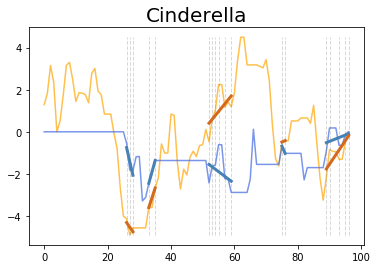

In [32]:
data=IMDB1[IMDB1['tconst']=='tt1661199']
curve(data,'Cinderella')

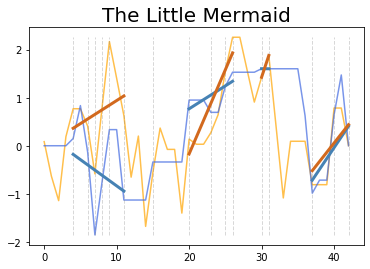

In [33]:
data=IMDB1[IMDB1['tconst']=='tt0097757'] 
curve(data,'The Little Mermaid')

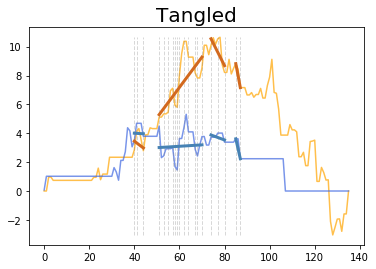

In [34]:
data=IMDB1[IMDB1['tconst']=='tt0398286'] 
curve(data,'Tangled')

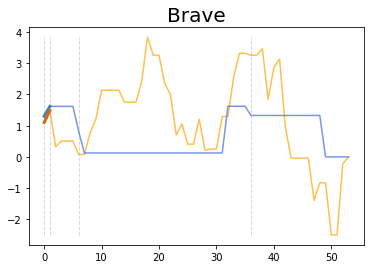

In [35]:
data=IMDB1[IMDB1['tconst']=='tt1217209'] 
curve(data,'Brave')

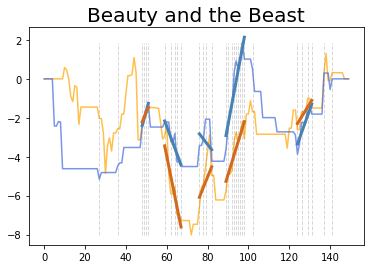

In [36]:
data=IMDB1[IMDB1['tconst']=='tt2771200']
curve(data,'Beauty and the Beast')

In [17]:
def gender (x,y):
    a=pd.DataFrame()
    a['K']=x
    a['gender']='male'
    b=pd.DataFrame()
    b['K']=y
    b['gender']='female'
    a=a.append(b)
    return a

In [18]:
def sig(x):
    if 0.01<x<=0.05:
        return '*'
    if 0.001<x<=0.01:
        return '**'
    if x<0.001:
        return '***'
    if x>0.05:
        return 'ns'

In [19]:
def cn(x,y,z):
    m_cn=[x[i] for i in y]
    m_cn=normalized(m_cn)
    diction_m=dict(list(zip(y,m_cn)))
    m_cn=np.cumsum([diction_m[i] if i in diction_m else 0 for i in range(len(x))])
    f_cn=[x[i] for i in z]
    f_cn=normalized(m_cn)
    diction_m=dict(list(zip(y,f_cn)))
    f_cn=np.cumsum([diction_m[i] if i in diction_m else 0 for i in range(len(x))])
    x=np.array(f_cn+m_cn)
    m_cn=(np.array(m_cn)-np.min(x))/(np.max(x)-np.min(x))
    f_cn=(np.array(f_cn)-np.min(x))/(np.max(x)-np.min(x))
    return m_cn,f_cn

In [20]:
def slope1(cum_e,tp,l,threshold):
#     threshold=l/threshold
    tp_e=[[i,cum_e[i]] for i in tp]
    a=[]
    for i in range(len(tp_e)-1):
        if (tp_e[i+1][0]-tp_e[i][0])>threshold:
            a.append(i+1)

    a=[0]+a+[len(tp_e)]

    b=[]
    for i in range(len(a)-1):
        b.append(tp_e[a[i]:a[i+1]])
        b=[i for i in b if len(i)!=0]
    return b

In [21]:
def k(b,w):
    try:
        a=[]
        for i in b:
            if len(i)==0:
                continue
            if len(i)==1:
#                 a.append([0,1])
                x=i[0][0]
                if (len(w)-1)>x>0:
                    k=(w[x]-w[x-1])/1
                    a.append([k,1])
#                     a.append([k,[x,x+1]])
                elif x==0:
                    k=(w[x+1]-w[x])/1
                    a.append([k,1])
#                     a.append([0,[0,1]])
                else:
                    k=(w[x]-w[x-1])/1
                    a.append([k,1])
#                     a.append([k,[x,x+1]])
#             if len(i)<4:
#                 continue
            if len(i)>1:
                x=[j[0] for j in i] #non_normalize
                y=[j[1] for j in i] #non_normalize
                poly = np.polyfit(x,y,deg=1)
#                 a.append([poly[0],[x[0],x[-1]+1]])
                a.append([poly[0],len(x)]) #number
#                 a.append([poly[0],x[-1]-x[0]]) #length
#                 a.append(poly[0])
        return a
    except Exception as e:
        return np.nan
        pass

In [22]:
def hist(data,n):
    tp=eval(data['tp'].values[0])
    f=eval(data['female_a'].values[0])
    m=eval(data['male_a'].values[0])
    emotion=eval(data['emotion'].values[0])
    l=data['len'].values[0]
    m_cn,f_cn=cn(emotion,m,f)
    threshold=3
    m_b=slope1(m_cn,tp,l,threshold)
    f_b=slope1(f_cn,tp,l,threshold)
    a1=k(m_b,m_cn)
    a=k(f_b,f_cn)
    
    if n in ['Cinderella']:
        tp=[26, 27, 28, 33, 35, 52, 53, 54, 55, 57, 59, 75, 76, 89, 90, 93, 95, 96]
        f=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 81, 84, 85, 86, 87, 88, 89, 90, 91, 93, 95, 96]
        m=[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 52, 53, 54, 55, 57, 59, 65, 66, 67, 75, 76, 82, 83, 89, 90, 93, 95, 96]
        emotion=eval(IMDB1[IMDB1['tconst']=='tt1661199']['emotion'].values[0])
        l=IMDB1[IMDB1['tconst']=='tt1661199']['len'].values[0]
        m_cn,f_cn=cn(emotion,m,f)
        threshold=3
        m_b=slope1(m_cn,tp,l,threshold)
        f_b=slope1(f_cn,tp,l,threshold)
        a1=k(m_b,m_cn)
        a=k(f_b,f_cn)
    a1=[i for i in a1 if i[0]>0]
    b1=[]
    for i in a1:
        for j in range(i[1]):
            b1.append(i[0])
    a=[i for i in a if i[0]>0]
    b=[]
    for i in a:
        for j in range(i[1]):
    if len(b)>len(b1):
        b1=b1+[0]*(len(b)-len(b1))
    else:
        b=b+[0]*(len(b1)-len(b))
    v,p=stats.ttest_ind(b,b1)      
    d=gender(b1,b)
    sns.barplot(x='gender',y='K',data = d)
    ax.set_ylabel(None,fontsize=15)
    ax.set_xlabel('Gender',fontsize=15)

In [23]:
def hist1(data,n):
    tp=eval(data['tp'].values[0])
    f=eval(data['female_a'].values[0])
    m=eval(data['male_a'].values[0])
    emotion=eval(data['emotion'].values[0])
    l=data['len'].values[0]
    m_cn,f_cn=cn(emotion,m,f)
    threshold=3
    m_b=slope1(m_cn,tp,l,threshold)
    f_b=slope1(f_cn,tp,l,threshold)
    a1=k(m_b,m_cn)
    a=k(f_b,f_cn)
    if n in ['Cinderella']:
        tp=[26, 27, 28, 33, 35, 52, 53, 54, 55, 57, 59, 75, 76, 89, 90, 93, 95, 96]
        f=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 81, 84, 85, 86, 87, 88, 89, 90, 91, 93, 95, 96]
        m=[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 52, 53, 54, 55, 57, 59, 65, 66, 67, 75, 76, 82, 83, 89, 90, 93, 95, 96]
        emotion=eval(IMDB1[IMDB1['tconst']=='tt1661199']['emotion'].values[0])
        l=IMDB1[IMDB1['tconst']=='tt1661199']['len'].values[0]
        m_cn,f_cn=cn(emotion,m,f)
        threshold=3
        m_b=slope1(m_cn,tp,l,threshold)
        f_b=slope1(f_cn,tp,l,threshold)
        a1=k(m_b,m_cn)
        a=k(f_b,f_cn)
    a1=[i for i in a1 if i[0]>0]
    b1=[]
    for i in a1:
        for j in range(i[1]):
            b1.append(i[0])
    a=[i for i in a if i[0]>0]

    b=[]
    for i in a:
        for j in range(i[1]):
            b.append(i[0])
    if len(b)>len(b1):
        b1=b1+[0]*(len(b)-len(b1))
    else:
        b=b+[0]*(len(b1)-len(b))
    v,p=stats.ttest_ind(b,b1)      
    d=gender(b1,b)
    sns.barplot(x='gender',y='K',data = d)
    ax.set_ylabel(None,fontsize=15)
    ax.set_xlabel('Gender',fontsize=15)
    return p

/Users/xuhuimin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
2019-11-06 21:10:47,669 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,670 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,672 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,673 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaqu

2019-11-06 21:10:47,791 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,792 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,794 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,795 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,796 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,797 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,798 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be re

2019-11-06 21:10:47,858 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,859 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,861 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,862 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,863 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,864 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,865 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be re

2019-11-06 21:10:47,951 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,953 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,954 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,982 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,983 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,984 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:47,985 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be re

2019-11-06 21:10:48,374 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,402 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,404 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,405 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,407 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,409 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,410 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be re

2019-11-06 21:10:48,565 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,567 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,569 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,571 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,573 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,575 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2019-11-06 21:10:48,577 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be re

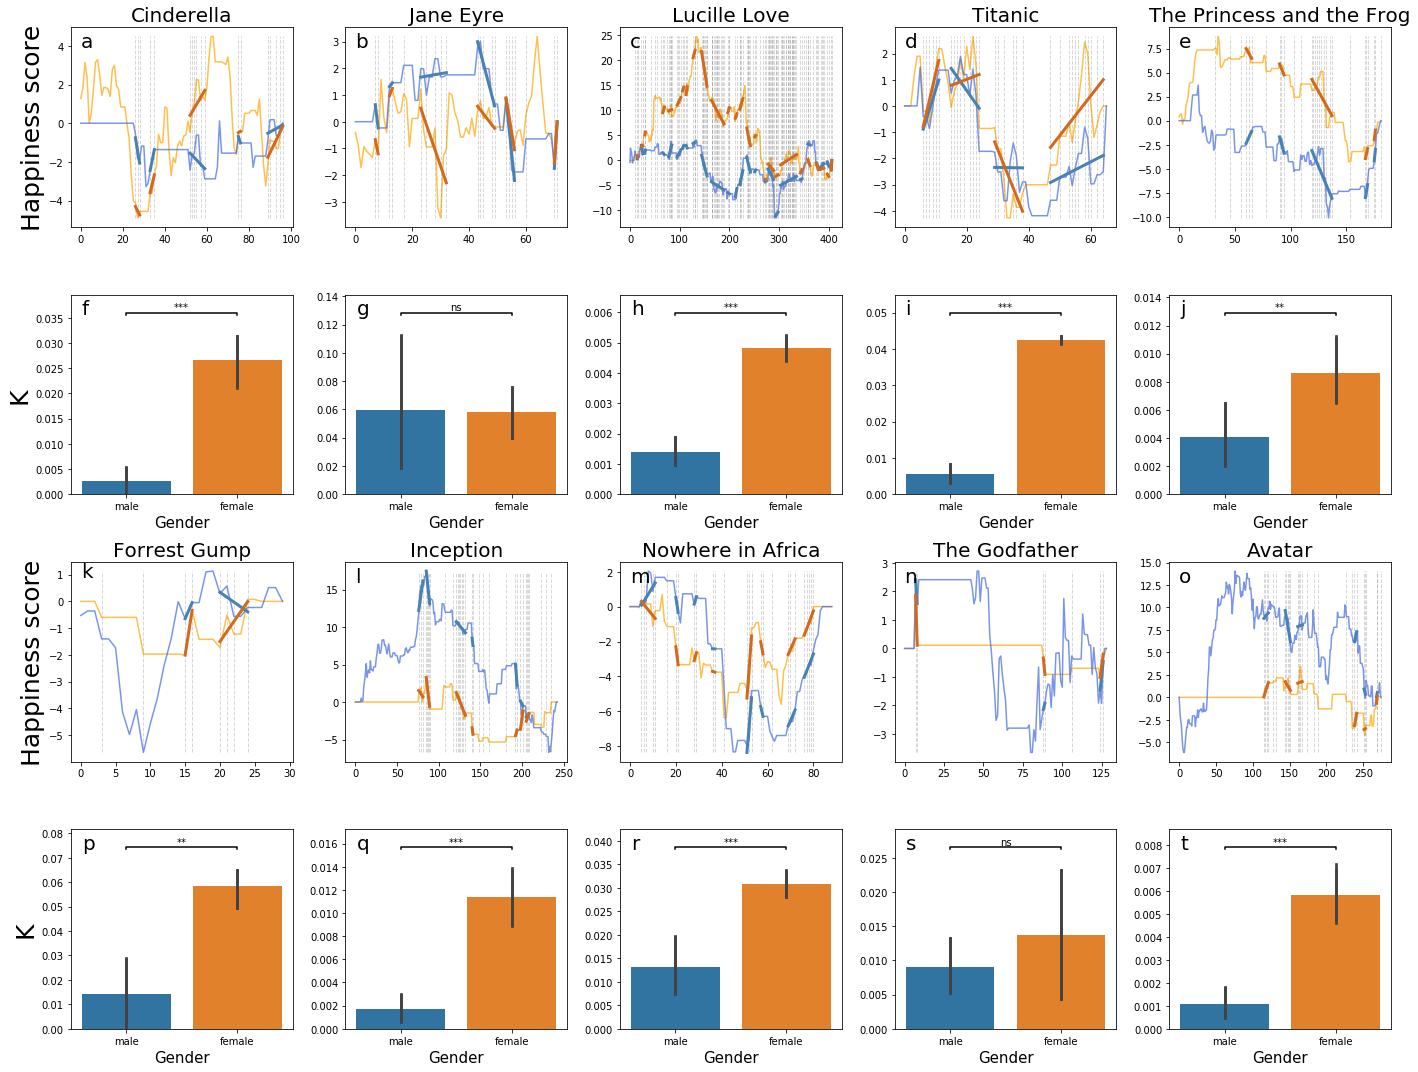

In [25]:
fig = plt.figure(figsize=(20,15))
ax=fig.add_subplot(4,5,1)
data=IMDB1[IMDB1['tconst']=='tt1661199']
curve(data,'Cinderella')
plt.ylabel('Happiness score',fontsize=25)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(0,b,'a',fontsize=20)
ax=fig.add_subplot(4,5,2)
data=IMDB1[IMDB1['tconst']=='tt1229822']
curve(data,'Jane Eyre')
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(0,b,'b',fontsize=20)
ax=fig.add_subplot(4,5,3)
data=IMDB1[IMDB1['tconst']=='tt0004272']
curve(data,'Lucille Love')
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(0,b,'c',fontsize=20)
ax=fig.add_subplot(4,5,4)
data=IMDB1[IMDB1['tconst']=='tt0120338']
curve(data,'Titanic')
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(0,b,'d',fontsize=20)
ax=fig.add_subplot(4,5,5)
data=IMDB1[IMDB1['tconst']=='tt0780521']
curve(data,'The Princess and the Frog')
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(0,b,'e',fontsize=20)

ax=fig.add_subplot(4,5,6)
data=IMDB1[IMDB1['tconst']=='tt1661199']
hist(data,'Cinderella')
ax.set_ylim([0,ax.get_ylim()[1]*1.2])
x1, x2 = 0, 1  
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
y, h, col = b , (ax.get_ylim()[1]-ax.get_ylim()[0])/100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, sig(hist1(data,'Cinderella')), ha='center', va='bottom', color=col)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(-0.4,b,'f',fontsize=20)
ax.set_ylabel('K',fontsize=25)
ax=fig.add_subplot(4,5,7)
data=IMDB1[IMDB1['tconst']=='tt1229822']
hist(data,'Jane Eyre')
ax.set_ylim([0,ax.get_ylim()[1]*1.2])
x1, x2 = 0, 1  
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
y, h, col = b , (ax.get_ylim()[1]-ax.get_ylim()[0])/100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, sig(hist1(data,'Jane Eyre')), ha='center', va='bottom', color=col)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(-0.4,b,'g',fontsize=20)
ax=fig.add_subplot(4,5,8)
data=IMDB1[IMDB1['tconst']=='tt0004272']
hist(data,'Lucille Love')
ax.set_ylim([0,ax.get_ylim()[1]*1.2])
x1, x2 = 0, 1  
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
y, h, col = b , (ax.get_ylim()[1]-ax.get_ylim()[0])/100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, sig(hist1(data,'Gone with the wind')), ha='center', va='bottom', color=col)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(-0.4,b,'h',fontsize=20)
ax=fig.add_subplot(4,5,9)
data=IMDB1[IMDB1['tconst']=='tt0120338']
hist(data,'Titanic')
ax.set_ylim([0,ax.get_ylim()[1]*1.2])
x1, x2 = 0, 1  
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
y, h, col = b , (ax.get_ylim()[1]-ax.get_ylim()[0])/100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, sig(hist1(data,'Titanic')), ha='center', va='bottom', color=col)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(-0.4,b,'i',fontsize=20)
ax=fig.add_subplot(4,5,10)
data=IMDB1[IMDB1['tconst']=='tt0780521']
hist(data,'The Princess and the Frog')
ax.set_ylim([0,ax.get_ylim()[1]*1.2])
x1, x2 = 0, 1  
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
y, h, col = b , (ax.get_ylim()[1]-ax.get_ylim()[0])/100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, sig(hist1(data,'Beauty and the Beast')), ha='center', va='bottom', color=col)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(-0.4,b,'j',fontsize=20)

ax=fig.add_subplot(4,5,11)
data=IMDB1[IMDB1['tconst']=='tt0109830']
plt.ylabel('Happiness score',fontsize=25)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(0,b,'k',fontsize=20)
curve(data,'Forrest Gump')
ax=fig.add_subplot(4,5,12)
data=IMDB1[IMDB1['tconst']=='tt1375666']
curve(data,'Inception')
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(0,b,'l',fontsize=20)
ax=fig.add_subplot(4,5,13)
data=IMDB1[IMDB1['tconst']=='tt0161860']
curve(data,'Nowhere in Africa')
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(0,b,'m',fontsize=20)
ax=fig.add_subplot(4,5,14)
data=IMDB1[IMDB1['tconst']=='tt0068646']
curve(data,'The Godfather')
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(0,b,'n',fontsize=20)
ax=fig.add_subplot(4,5,15)
data=IMDB1[IMDB1['tconst']=='tt0499549']
curve(data,'Avatar')
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(0,b,'o',fontsize=20)

ax=fig.add_subplot(4,5,16)
data=IMDB1[IMDB1['tconst']=='tt0109830']
hist(data,'Forrest Gump')
ax.set_ylim([0,ax.get_ylim()[1]*1.2])
x1, x2 = 0, 1  
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
y, h, col = b , (ax.get_ylim()[1]-ax.get_ylim()[0])/100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, sig(hist1(data,'Forrest Gump')), ha='center', va='bottom', color=col)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(-0.4,b,'p',fontsize=20)
ax.set_ylabel('K',fontsize=25)
ax=fig.add_subplot(4,5,17)
data=IMDB1[IMDB1['tconst']=='tt1375666']
hist(data,'Inception')
ax.set_ylim([0,ax.get_ylim()[1]*1.2])
x1, x2 = 0, 1  
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
y, h, col = b , (ax.get_ylim()[1]-ax.get_ylim()[0])/100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, sig(hist1(data,'Inception')), ha='center', va='bottom', color=col)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(-0.4,b,'q',fontsize=20)
ax=fig.add_subplot(4,5,18)
data=IMDB1[IMDB1['tconst']=='tt0161860']
hist(data,'Nowhere in Africa')
ax.set_ylim([0,ax.get_ylim()[1]*1.2])
x1, x2 = 0, 1  
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
y, h, col = b , (ax.get_ylim()[1]-ax.get_ylim()[0])/100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, sig(hist1(data,'The Matrix')), ha='center', va='bottom', color=col)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(-0.4,b,'r',fontsize=20)
ax=fig.add_subplot(4,5,19)
data=IMDB1[IMDB1['tconst']=='tt0068646']
hist(data,'The Godfather')
ax.set_ylim([0,ax.get_ylim()[1]*1.2])
x1, x2 = 0, 1  
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
y, h, col = b , (ax.get_ylim()[1]-ax.get_ylim()[0])/100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, sig(hist1(data,'The Godfather')), ha='center', va='bottom', color=col)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(-0.4,b,'s',fontsize=20)
ax=fig.add_subplot(4,5,20)
data=IMDB1[IMDB1['tconst']=='tt0499549']
hist(data,'Avatar')
ax.set_ylim([0,ax.get_ylim()[1]*1.2])
x1, x2 = 0, 1  
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
y, h, col = b , (ax.get_ylim()[1]-ax.get_ylim()[0])/100, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, sig(hist1(data,'Avatar')), ha='center', va='bottom', color=col)
b=ax.get_ylim()[0]+(ax.get_ylim()[1]-ax.get_ylim()[0])*0.9
plt.text(-0.4,b,'t',fontsize=20)
plt.tight_layout()
plt.savefig('./picture/figure2.eps',dpi=300)
plt.show()